In [1]:
# @title Celda 1: Configuración, Imports y Conexión a BigQuery

# 1. INSTALACIONES (Descomenta y ejecuta si es necesario para tu Colab)
# Colab suele tener muchas, pero para estar seguro y si cambian de versión
# !pip install pandas google-cloud-bigquery scikit-learn lightgbm numpy toml

# 2. IMPORTS
import os
import json
import logging
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import datetime # Para manejar fechas

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier # Importación específica del clasificador
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 3. MOCK STREAMLIT PARA COMPATIBILIDAD (No lo borres si este código lo usarás como base para Streamlit en el futuro)
# Simula funciones de Streamlit para que el código que puede venir de una app de Streamlit funcione aquí sin errores.
class MockStreamlit:
    def cache_data(self, func=None, ttl=None):
        if func is None:
            return lambda f: f # Decorador llamado sin paréntesis
        return func
    def cache_resource(self, func=None):
        if func is None:
            return lambda f: f
        return func
    def warning(self, msg): print(f"WARNING (Streamlit Mock): {msg}")
    def info(self, msg): print(f"INFO (Streamlit Mock): {msg}")
    def error(self, msg): print(f"ERROR (Streamlit Mock): {msg}")
    def write(self, *args): print(*args) # Para debug de st.write
    def stop(self): print("Streamlit Mock: st.stop() llamado. Ejecución simulada detenida.")
st = MockStreamlit()


# 4. CONFIGURACIÓN BÁSICA DE LOGGING (solo print para Colab)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 5. CONSTANTES DEL PROYECTO (¡¡¡ADAPTA ESTO!!!)
GCP_PROJECT_ID = 'pokemon-cards-project' # <-- REEMPLAZA con tu Project ID de BigQuery
BIGQUERY_DATASET = "pokemon_dataset"
CARD_METADATA_TABLE = f"{GCP_PROJECT_ID}.{BIGQUERY_DATASET}.card_metadata"


# 6. RUTAS PARA MODELOS Y PREPROCESADORES (¡¡¡ADAPTA ESTO!!! Montar Drive es crucial si esta es tu ruta real)
# Esta es la base donde están/irán TUS ARCHIVOS DE MODELO y PREPROCESADORES.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED_PATH = '/content/drive/MyDrive/'
    print("Google Drive montado en /content/drive/MyDrive/.")
except Exception as e:
    logger.warning(f"No se pudo montar Google Drive: {e}. Asumiendo ruta local '.'")
    DRIVE_MOUNTED_PATH = './' # Fallback a directorio actual de Colab si Drive no se monta
    # Crea una carpeta 'model_files' en el directorio actual si no se monta Drive y no existe
    if not os.path.exists('model_files'): os.makedirs('model_files')
    print("WARNING: Operando en directorio local. Asegúrate que los modelos estén aquí o en 'model_files/'.")

# Subcarpeta para guardar los modelos del clasificador
# Se guardarán dentro de la carpeta 'mlp_v1' como subdirectorio
DRIVE_MODEL_BASE_PATH = os.path.join(DRIVE_MOUNTED_PATH, 'Proyecto API', 'RedNeuronal', 'mlp_v1') # <-- VERIFICA ESTA RUTA BASE
CLASSIFIER_MODELS_PATH = os.path.join(DRIVE_MODEL_BASE_PATH, 'classifier_models')
os.makedirs(CLASSIFIER_MODELS_PATH, exist_ok=True)
print(f"Los modelos del clasificador se guardarán en: {CLASSIFIER_MODELS_PATH}")


# 7. CONEXIÓN A BIGQUERY (Usa tu método preferido en Colab)
@st.cache_resource # Esto simula la caché de Streamlit para la conexión
def connect_to_bigquery_colab_fn():
    try:
        from google.colab import auth
        auth.authenticate_user() # Esto abre una ventana de autorización si no estás ya autenticado
        client = bigquery.Client(project=GCP_PROJECT_ID)
        logger.info("BigQuery Client: Conectado vía Colab Auth.")
        return client
    except Exception as e_colab:
        logger.error(f"BigQuery Client: Fallo de autenticación Colab: {e_colab}", exc_info=True)
        print("ERROR: Fallo de autenticación BigQuery. ¿Has ejecutado 'auth.authenticate_user()' y autorizado correctamente?")
        print("Opcional: Si usas Service Account JSON, súbelo a Files y configura 'service_account_file'.")
        # --- Si necesitas autenticación con Service Account JSON File en Colab, descomenta y ajusta ---
        # try:
        #     # Asume que tu service_account.json está subido a los Files de Colab
        #     path_to_service_account_json = 'your_service_account.json' # <-- CAMBIA ESTO
        #     if os.path.exists(path_to_service_account_json):
        #         creds = service_account.Credentials.from_service_account_file(path_to_service_account_json)
        #         client = bigquery.Client(credentials=creds, project=GCP_PROJECT_ID)
        #         logger.info("BigQuery Client: Conectado vía Service Account.")
        #         return client
        #     else:
        #         print(f"WARNING: Service Account JSON no encontrado en '{path_to_service_account_json}'.")
        #         return None
        # except Exception as se_json:
        #     logger.error(f"BigQuery Client: Error en autenticación por Service Account JSON: {se_json}", exc_info=True)
        return None # Devuelve None si todas las autenticaciones fallan

bq_client = connect_to_bigquery_colab_fn()
if bq_client is None:
    raise Exception("ERROR FATAL: No se pudo conectar a Google BigQuery. Por favor, revisa tus credenciales.")

print("\nCelda 1 Finalizada. ¡Continuar con la Celda 2!")

Mounted at /content/drive
Google Drive montado en /content/drive/MyDrive/.
Los modelos del clasificador se guardarán en: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/classifier_models

Celda 1 Finalizada. ¡Continuar con la Celda 2!


In [2]:
# @title Celda 2: Carga y Preparación del Dataset de Entrenamiento

# 8. FUNCIONES UTILITARIAS PARA CARGAR DATOS DE BIGQUERY (Copiadas de tu app.py)
# Las decoramos con @st.cache_data para que se parezcan a tu app, aunque aquí solo es un passthrough
# para la función real sin persistencia en disco de caché en Colab (a menos que uses tu propia cache)
@st.cache_data(ttl=3600) # ttl=3600 es para que Streamlit sepa, no afecta este notebook sin un disco de caché.
def get_latest_snapshot_info(_client: bigquery.Client) -> tuple[str | None, pd.Timestamp | None]:
    query = f"SELECT table_id FROM `{_client.project}.{BIGQUERY_DATASET}`.__TABLES__ WHERE STARTS_WITH(table_id, 'monthly_') ORDER BY table_id DESC LIMIT 1"
    try:
        results = _client.query(query).result()
        if results.total_rows > 0:
            latest_table_id_str = list(results)[0].table_id
            full_table_path = f"{_client.project}.{BIGQUERY_DATASET}.{latest_table_id_str}"
            date_str_from_suffix = latest_table_id_str.replace("monthly_", "")
            snapshot_date = pd.to_datetime(date_str_from_suffix, format='%Y_%m_%d')
            logger.info(f"SNAPSHOT_INFO: Usando tabla: {full_table_path}, Fecha Snapshot: {snapshot_date.date()}")
            return full_table_path, snapshot_date
        logger.warning("SNAPSHOT_TABLE: No se encontraron tablas snapshot 'monthly_...'.")
        return None, None
    except Exception as e:
        logger.error(f"SNAPSHOT_TABLE: Error: {e}", exc_info=True)
        print(f"Error crítico al obtener información del último snapshot: {e}")
        return None, None # Asegurarse de siempre devolver una tupla en caso de error

POKEMON_SUFFIXES_TO_REMOVE = [' VMAX', ' VSTAR', ' V-UNION', ' V', ' GX', ' EX', ' BREAK', ' Prism Star', ' Star', ' Radiant', ' δ', ' Tag Team', ' & ', ' Light', ' Dark', ' ◇', ' ☆']
MULTI_WORD_BASE_NAMES = ["Mr. Mime", "Mime Jr.", "Farfetch'd", "Sirfetch'd", "Ho-Oh", "Porygon-Z", "Type: Null", "Tapu Koko", "Tapu Lele", "Tapu Bulu", "Tapu Fini", "Mr. Rime", "Indeedee M", "Indeedee F", "Great Tusk", "Iron Treads"]

def get_true_base_name(name_str, supertype, suffixes, multi_word_bases):
    if not isinstance(name_str, str) or supertype != 'Pokémon': return name_str
    for mw_base in multi_word_bases:
        if name_str.startswith(mw_base): return mw_base
    cleaned_name = name_str
    for suffix in suffixes:
        if cleaned_name.endswith(suffix): cleaned_name = cleaned_name[:-len(suffix)].strip()
    return cleaned_name if cleaned_name else name_str

@st.cache_data(ttl=3600)
def get_card_metadata_with_aliases_fn(_client: bigquery.Client) -> pd.DataFrame:
    # Trae name/artist y sus alias pokemon_name/artist_name
    query = f"""
    SELECT
        id, name, name AS pokemon_name,
        supertype, subtypes, types,
        rarity, set_id, set_name,
        artist, artist AS artist_name,
        images_large AS image_url,
        cardmarket_url, tcgplayer_url
    FROM `{CARD_METADATA_TABLE}`
    """
    logger.info(f"METADATA_BQ: Ejecutando query para metadatos: {query[:100]}...")
    try:
        df = _client.query(query).to_dataframe()
        if df.empty: logger.warning("METADATA_BQ: DataFrame de metadatos vacío."); return pd.DataFrame()
        expected_cols = ['id', 'name', 'pokemon_name', 'artist', 'artist_name', 'supertype', 'subtypes', 'types', 'rarity', 'set_id', 'set_name', 'image_url', 'cardmarket_url', 'tcgplayer_url']
        for col in expected_cols:
            if col not in df.columns:
                # Intenta crear aliases si existen las columnas base
                if col == 'pokemon_name' and 'name' in df.columns: df['pokemon_name'] = df['name']
                elif col == 'artist_name' and 'artist' in df.columns: df['artist_name'] = df['artist']
                else:
                    df[col] = 'Unknown_Placeholder' # Por defecto para columnas que no vienen ni se aliasan
                    logger.warning(f"METADATA_BQ: Columna '{col}' no encontrada ni en la query ni como alias. Placeholder añadido.")

        df['base_pokemon_name_display'] = df.apply(lambda row: get_true_base_name(row['name'], row['supertype'], POKEMON_SUFFIXES_TO_REMOVE, MULTI_WORD_BASE_NAMES), axis=1)
        logger.info(f"METADATA_BQ: Metadatos cargados y procesados. Total filas: {len(df)}.")
        return df
    except Exception as e:
        logger.error(f"METADATA_BQ: Error: {e}", exc_info=True)
        print(f"Error al cargar metadatos de BigQuery: {e}")
        return pd.DataFrame()

def get_price_data_for_training_fn(_client: bigquery.Client, full_table_path: str) -> pd.DataFrame:
    query = f"""
    SELECT
        id, cm_averageSellPrice AS price
    FROM `{full_table_path}`
    """
    try:
        df_prices = _client.query(query).to_dataframe()
        df_prices['price'] = pd.to_numeric(df_prices['price'], errors='coerce')
        logger.info(f"PREPARE_PRICES: Datos de precios de '{full_table_path}' cargados: {len(df_prices)} filas.")
        return df_prices
    except Exception as e:
        logger.error(f"PREPARE_PRICES: Error: {e}", exc_info=True)
        print(f"Error al cargar datos de precios: {e}")
        return pd.DataFrame()


# 9. CONSTRUCCIÓN DEL DATASET DE ENTRENAMIENTO COMPLETO PARA CLASIFICADOR
print("\n--- Iniciando construcción del dataset de entrenamiento para el clasificador ---")

latest_table_path, latest_snapshot_date = get_latest_snapshot_info(bq_client)
if not latest_table_path or latest_snapshot_date is None:
    raise Exception("ERROR: No se pudo obtener información del último snapshot para cargar precios. Abortando entrenamiento.")

df_latest_prices = get_price_data_for_training_fn(bq_client, latest_table_path)
if df_latest_prices.empty:
    raise Exception(f"ERROR: No se cargaron precios del último snapshot '{latest_table_path}'. Abortando entrenamiento.")

all_card_metadata_df_colab = get_card_metadata_with_aliases_fn(bq_client) # Usamos la función del notebook para metadatos
if all_card_metadata_df_colab.empty:
    raise Exception("ERROR: No se pudieron cargar metadatos completos para el entrenamiento. Abortando entrenamiento.")


# Lógica para obtener el snapshot previo (t_minus_1)
def get_previous_month_snapshot_path_fn(current_snapshot_date: pd.Timestamp, _client: bigquery.Client) -> str | None:
    first_day_of_current_month = current_snapshot_date.replace(day=1)
    last_day_of_previous_month = first_day_of_current_month - pd.Timedelta(days=1)
    prev_table_suffix = last_day_of_previous_month.strftime('monthly_%Y_%m_%d')
    prev_full_table_path = f"{_client.project}.{BIGQUERY_DATASET}.{prev_table_suffix}"

    # Opcional: verificar si la tabla existe en BQ
    # from google.cloud.bigquery import NotFound
    # try: _client.get_table(prev_full_table_path)
    # except NotFound: logger.warning(f"Tabla previa no encontrada: {prev_full_table_path}"); return None
    return prev_full_table_path

previous_table_path = get_previous_month_snapshot_path_fn(latest_snapshot_date, bq_client)
df_previous_prices = None
if previous_table_path:
    df_previous_prices = get_price_data_for_training_fn(bq_client, previous_table_path)
    if df_previous_prices.empty:
        print(f"WARNING: No se cargaron precios de la tabla previa '{previous_table_path}'.")
else:
    print("WARNING: No se pudo determinar la ruta de la tabla previa o la tabla previa no existe.")


# Unir metadatos y precios
df_train_classifier_data = all_card_metadata_df_colab.merge(
    df_latest_prices.rename(columns={'price': 'price_t0'}), on='id', how='left'
)

if df_previous_prices is not None and not df_previous_prices.empty:
    df_train_classifier_data = df_train_classifier_data.merge(
        df_previous_prices.rename(columns={'price': 'price_t_minus_1'}), on='id', how='left'
    )
    print(f"Unión con precios del snapshot previo completada. Filas: {len(df_train_classifier_data)}")
else:
    print("WARNING: No hay datos de precios previos. La feature 'price_t_minus_1' se rellenará con median.")
    df_train_classifier_data['price_t_minus_1'] = np.nan


# Imputar precios NaN antes de calcular el cambio si es necesario
df_train_classifier_data['price_t0'] = pd.to_numeric(df_train_classifier_data['price_t0'], errors='coerce')
# Imputación para 'price_t_minus_1' que se usa en features numéricas
# Si el precio_t0 también puede ser NaN y se usa la mediana, hay que manejarlo.
median_price_t0_actual = df_train_classifier_data['price_t0'].median()
df_train_classifier_data['price_t_minus_1'] = df_train_classifier_data['price_t_minus_1'].fillna(median_price_t0_actual)
df_train_classifier_data['price_t_minus_1'] = pd.to_numeric(df_train_classifier_data['price_t_minus_1'], errors='coerce')


# Calcular price_change_from_prev
df_train_classifier_data['price_change_from_prev'] = (df_train_classifier_data['price_t0'] - df_train_classifier_data['price_t_minus_1']) / df_train_classifier_data['price_t_minus_1'].replace(0, np.nan)
df_train_classifier_data['price_change_from_prev'] = df_train_classifier_data['price_change_from_prev'].fillna(0) # Si el cambio no se puede calcular, asumir 0

# 11. DEFINICIÓN DE LA VARIABLE OBJETIVO (y)
# Clasificar por precio ACTUAL (price_t0)
BULK_THRESHOLD = 5.0
CHEAP_THRESHOLD = 50.0
EXPENSIVE_THRESHOLD = 200.0

def classify_current_price_category(price: float) -> str:
    if pd.isna(price): return 'Unknown'
    elif price < BULK_THRESHOLD: return 'Bulk'
    elif price < CHEAP_THRESHOLD: return 'Asequible'
    elif price < EXPENSIVE_THRESHOLD: return 'Cara'
    else: return 'Coleccionista'

df_train_classifier_data['price_category_target'] = df_train_classifier_data['price_t0'].apply(classify_current_price_category)

print("\nConteo de categorías de precio para el target (ANTES de filtrar 'Unknown'):")
print(df_train_classifier_data['price_category_target'].value_counts())

df_train_classifier = df_train_classifier_data[df_train_classifier_data['price_category_target'] != 'Unknown'].copy()
if df_train_classifier.empty:
    raise Exception("El DataFrame para entrenamiento de clasificador está vacío después de clasificar precios.")

X_train_features_df = df_train_classifier
y_train_target_series = df_train_classifier['price_category_target']

print(f"\nDatos preparados para clasificador: {len(X_train_features_df)} filas.")
print(f"Conteo de categorías FINAL del target:\n{y_train_target_series.value_counts()}")
print(f"Columnas del DataFrame de features para clasificador: {X_train_features_df.columns.tolist()}")

print("\nCelda 2 Finalizada. ¡Continuar con la Celda 3!")


--- Iniciando construcción del dataset de entrenamiento para el clasificador ---


ERROR:__main__:PREPARE_PRICES: Error: 404 Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US; reason: notFound, message: Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US

Location: US
Job ID: fe822489-e917-4d6f-8616-85360a44aa9b
Traceback (most recent call last):
  File "<ipython-input-2-3dc261992533>", line 79, in get_price_data_for_training_fn
    df_prices = _client.query(query).to_dataframe()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/job/query.py", line 2074, in to_dataframe
    query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/_tqdm_helpers.py", line 107, in wait_for_query
    return query_job.result(max_results=max_r

Error al cargar datos de precios: 404 Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US; reason: notFound, message: Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US

Location: US
Job ID: fe822489-e917-4d6f-8616-85360a44aa9b


Conteo de categorías de precio para el target (ANTES de filtrar 'Unknown'):
price_category_target
Bulk             14656
Asequible         3264
Cara               438
Unknown            414
Coleccionista      104
Name: count, dtype: int64

Datos preparados para clasificador: 18462 filas.
Conteo de categorías FINAL del target:
price_category_target
Bulk             14656
Asequible         3264
Cara               438
Coleccionista      104
Name: count, dtype: int64
Columnas del DataFrame de features para clasificador: ['id', 'name', 'pokemon_name', 'supertype', 'subtypes', 'types', 'rarity', 'set_id', 'set_name', 'artist', 'artist_name', 'image_url', 'cardmarke

In [4]:
# @title Celda 3: Preprocesamiento y Entrenamiento del Clasificador

# --- IMPORTS ESPECÍFICOS PARA ESTA CELDA (Por seguridad) ---
import joblib # <--- AÑADIDO
import pandas as pd # <--- AÑADIDO
import numpy as np # <--- AÑADIDO
from sklearn.preprocessing import OneHotEncoder, StandardScaler # <-- AÑADIDO (aunque están arriba)
from lightgbm import LGBMClassifier # <-- AÑADIDO
from sklearn.model_selection import train_test_split # <-- AÑADIDO
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # <-- AÑADIDO

# Es importante que las variables globales como CLASSIFIER_MODELS_PATH
# estén disponibles desde la Celda 1. Si esta celda falla de nuevo,
# podría ser porque las variables globales no persisten si reinicias el kernel
# y solo ejecutas esta celda. Para evitar eso, siempre ejecuta las celdas en orden.


print("\n--- Preprocesamiento y Entrenamiento del Clasificador ---")

# Features del clasificador:
CATEGORICAL_FEATURES_CLASSIFIER = [
    'artist_name', 'pokemon_name', 'rarity', 'set_name', 'types', 'supertype', 'subtypes' # Se asume que df_train_classifier_data ya las tiene aliasadas
]
NUMERIC_FEATURES_CLASSIFIER = [
    'price_t_minus_1',
    'price_change_from_prev'
]
ALL_FEATURES_CLASSIFIER = NUMERIC_FEATURES_CLASSIFIER + CATEGORICAL_FEATURES_CLASSIFIER

# Verificar que todas las features necesarias existan
missing_cols_clf = [col for col in ALL_FEATURES_CLASSIFIER if col not in X_train_features_df.columns]
if missing_cols_clf:
    raise Exception(f"ERROR: Faltan columnas necesarias para el clasificador en df_train_classifier: {missing_cols_clf}")


# Preprocesamiento
ohe_classifier = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_for_ohe = X_train_features_df[CATEGORICAL_FEATURES_CLASSIFIER].astype(str)
X_cat_encoded = ohe_classifier.fit_transform(X_cat_for_ohe)
print(f"Categóricas codificadas (shape): {X_cat_encoded.shape}")

scaler_classifier = StandardScaler()
X_num_for_scaler = X_train_features_df[NUMERIC_FEATURES_CLASSIFIER].fillna(0) # Rellenar NaNs con 0 antes de escalar
X_num_scaled = scaler_classifier.fit_transform(X_num_for_scaler)
print(f"Numéricas escaladas (shape): {X_num_scaled.shape}")

X_classifier_final = np.hstack([X_num_scaled, X_cat_encoded])
print(f"Shape de X final para el clasificador: {X_classifier_final.shape}")


# Split de Datos
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classifier_final, y_train_target_series, test_size=0.2, random_state=42, stratify=y_train_target_series
)

# Entrenamiento del Clasificador (LightGBM Classifier)
print("\nIniciando entrenamiento del LGBMClassifier...")
lgbm_classifier_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y_train_target_series.unique()),
    random_state=42,
    n_estimators=100
)
lgbm_classifier_model.fit(X_train_clf, y_train_clf)
print("✅ Entrenamiento del LGBMClassifier completado.")

# Evaluación
print("\n--- Evaluación del Clasificador ---")
y_pred_clf = lgbm_classifier_model.predict(X_test_clf)
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test_clf, y_pred_clf))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_clf, y_pred_clf, labels=lgbm_classifier_model.classes_))

# Guardado del Modelo y Preprocesadores
CLASSIFIER_MODEL_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'lgbm_price_classifier.pkl')
CLASSIFIER_OHE_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'ohe_classifier_meta.pkl')
CLASSIFIER_SCALER_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'scaler_classifier_num.pkl')
CLASSIFIER_FEATURES_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'classifier_features.json')

joblib.dump(lgbm_classifier_model, CLASSIFIER_MODEL_PATH)
joblib.dump(ohe_classifier, CLASSIFIER_OHE_PATH)
joblib.dump(scaler_classifier, CLASSIFIER_SCALER_PATH)

classifier_config_app = {
    'numeric_features': NUMERIC_FEATURES_CLASSIFIER,
    'categorical_features': CATEGORICAL_FEATURES_CLASSIFIER,
    'target_classes': list(lgbm_classifier_model.classes_),
    'all_input_features_ordered': ALL_FEATURES_CLASSIFIER
}
with open(CLASSIFIER_FEATURES_PATH, 'w') as f:
    json.dump(classifier_config_app, f)

print(f"\n✅ Modelo de Clasificación guardado en: {CLASSIFIER_MODEL_PATH}")
print(f"✅ Preprocesadores de Clasificación guardados.")
print(f"✅ Configuración de features para Clasificador guardada en: {CLASSIFIER_FEATURES_PATH}")


--- Preprocesamiento y Entrenamiento del Clasificador ---
Categóricas codificadas (shape): (18462, 4836)
Numéricas escaladas (shape): (18462, 2)
Shape de X final para el clasificador: (18462, 4838)

Iniciando entrenamiento del LGBMClassifier...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 14769, number of used features: 392
[LightGBM] [Info] Start training from score -1.732797
[LightGBM] [Info] Start training from score -0.230892
[LightGBM] [Info] Start training from score -3.739499
[LightGBM] [Info] Start training from score -5.181445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✅ Modelo de Clasificación guardado en: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/classifier_models/lgbm_price_classifier.pkl
✅ Preprocesadores de Clasificación guardados.
✅ Configuración de features para Clasificador guardada en: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/classifier_models/classifier_features.json



--- Generando Visualizaciones de Resultados del Clasificador ---

1. Visualizando la Matriz de Confusión...


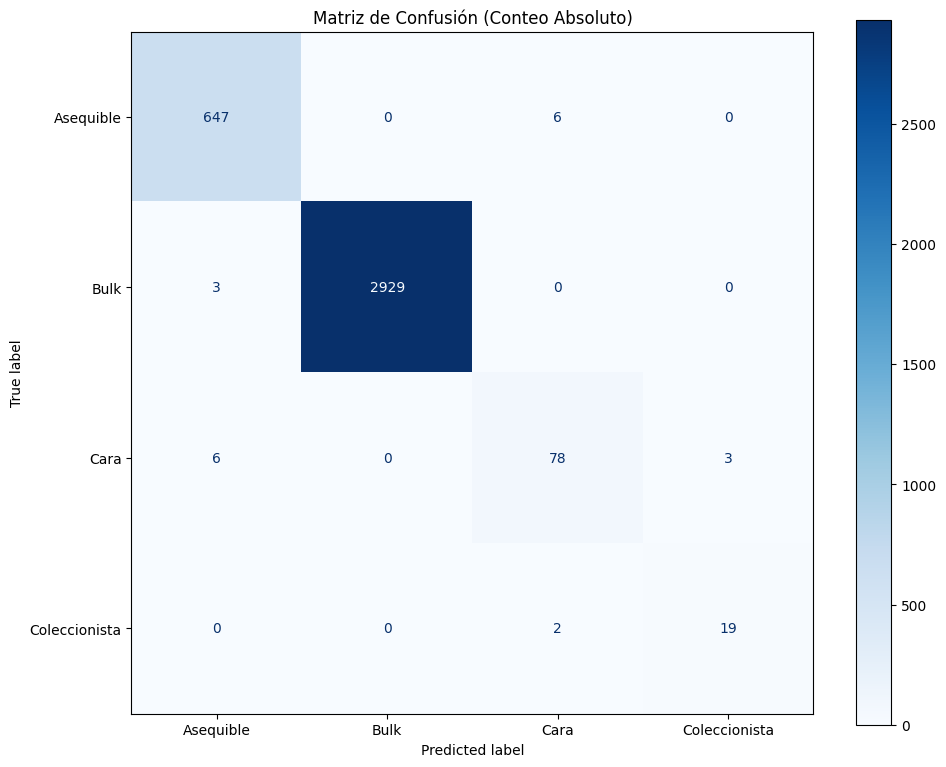

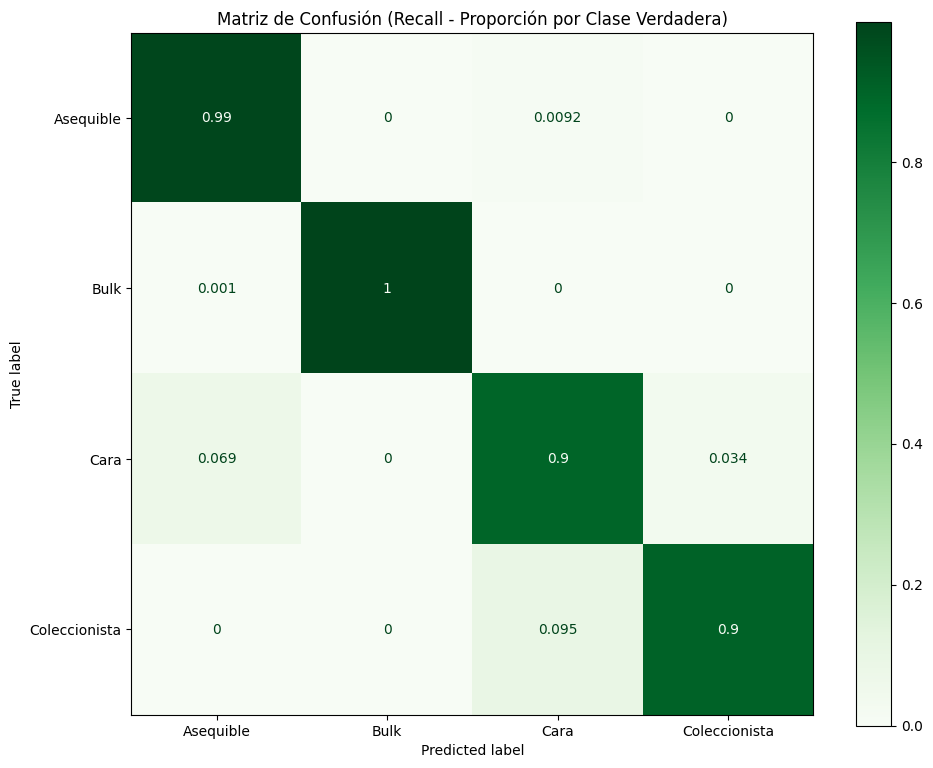


2. Visualizando el Conteo de Predicciones por Clase...


<Figure size 1200x600 with 0 Axes>

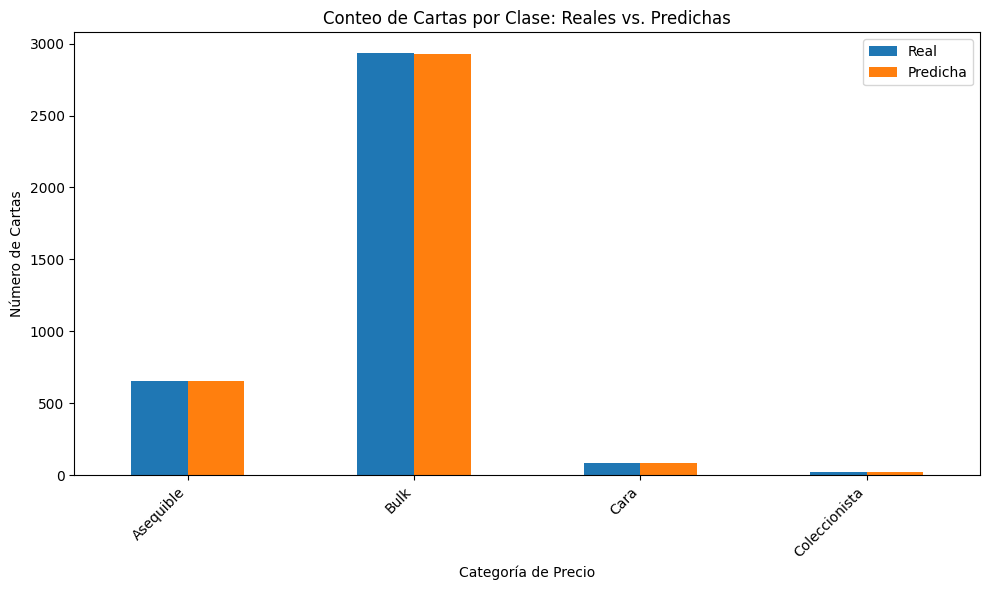


3. Mostrando el Reporte de Clasificación...
               precision    recall  f1-score      support
Asequible       0.986280  0.990812  0.988541   653.000000
Bulk            1.000000  0.998977  0.999488  2932.000000
Cara            0.906977  0.896552  0.901734    87.000000
Coleccionista   0.863636  0.904762  0.883721    21.000000
accuracy        0.994584  0.994584  0.994584     0.994584
macro avg       0.939223  0.947776  0.943371  3693.000000
weighted avg    0.994607  0.994584  0.994591  3693.000000


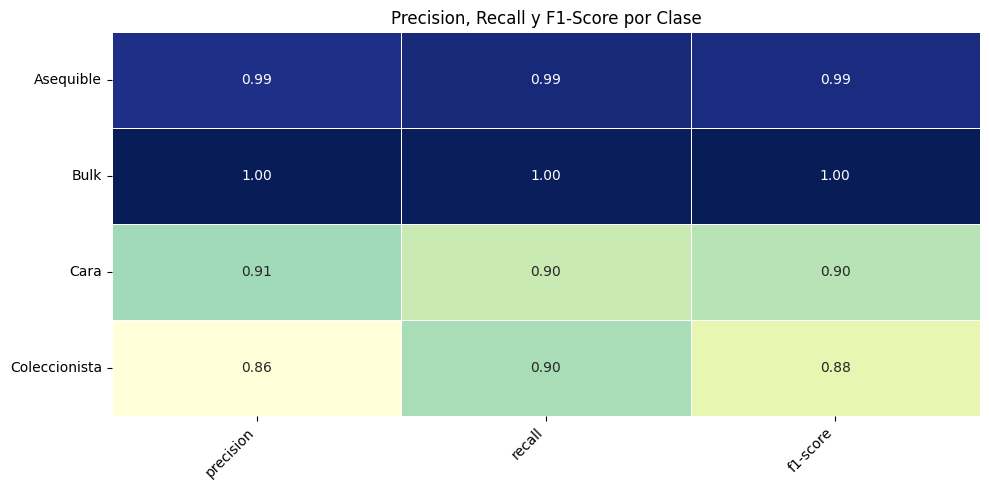


4. Mostrando un resumen de aciertos y fallos...

Predicciones Correctas: 3673 / 3693 (99.46%)
Predicciones Incorrectas: 20 / 3693 (0.54%)

Visualizaciones Finalizadas.


In [6]:
# @title Celda 4: Visualización de Resultados del Modelo de Clasificación

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd # Para df en reporte si es necesario

print("\n--- Generando Visualizaciones de Resultados del Clasificador ---")

# Verificar si los resultados del entrenamiento están disponibles
if 'y_test_clf' not in locals() or 'y_pred_clf' not in locals() or 'lgbm_classifier_model' not in locals():
    print("ERROR: Los resultados de entrenamiento (y_test_clf, y_pred_clf) o el modelo no están disponibles. Ejecuta la Celda 3 primero.")
else:
    # 1. Gráfico de Matriz de Confusión
    print("\n1. Visualizando la Matriz de Confusión...")
    fig, ax = plt.subplots(figsize=(10, 8))

    # Asegúrate de que las clases se usen en el mismo orden que el modelo las predice/espera
    labels_order = lgbm_classifier_model.classes_ # El modelo guarda el orden de sus clases

    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_test_clf, y_pred_clf,
        display_labels=labels_order,
        cmap=plt.cm.Blues, # Color para la matriz
        normalize=None, # None para mostrar conteos, 'true' para normalizar por fila (recall)
        ax=ax
    )
    #cm_display.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False) # older way

    ax.set_title('Matriz de Confusión (Conteo Absoluto)')
    plt.tight_layout()
    plt.show()

    # Opcional: Matriz de Confusión Normalizada por fila (Recall)
    fig_norm, ax_norm = plt.subplots(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test_clf, y_pred_clf,
        display_labels=labels_order,
        cmap=plt.cm.Greens, # Otro color para diferenciar
        normalize='true', # Normaliza por fila (recall)
        ax=ax_norm
    )
    ax_norm.set_title('Matriz de Confusión (Recall - Proporción por Clase Verdadera)')
    plt.tight_layout()
    plt.show()

    # 2. Conteo de Predicciones por Clase (Barras)
    print("\n2. Visualizando el Conteo de Predicciones por Clase...")
    plt.figure(figsize=(12, 6))

    # Crear un DataFrame para conteos fáciles
    results_df_temp = pd.DataFrame({'Real': y_test_clf, 'Predicha': y_pred_clf})

    # Conteo de valores reales y predichos
    real_counts = results_df_temp['Real'].value_counts().sort_index(key=lambda x: [labels_order.tolist().index(i) for i in x])
    pred_counts = results_df_temp['Predicha'].value_counts().sort_index(key=lambda x: [labels_order.tolist().index(i) for i in x])

    # Unir para graficar lado a lado
    counts_combined = pd.DataFrame({'Real': real_counts, 'Predicha': pred_counts}).fillna(0) # Rellenar con 0 si una clase no fue predicha/no estuvo en el real
    counts_combined.plot(kind='bar', figsize=(10, 6))
    plt.title('Conteo de Cartas por Clase: Reales vs. Predichas')
    plt.xlabel('Categoría de Precio')
    plt.ylabel('Número de Cartas')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3. Reporte de Clasificación (con seaborn heatmap opcional para F1/Precision/Recall)
    print("\n3. Mostrando el Reporte de Clasificación...")
    report_dict = classification_report(y_test_clf, y_pred_clf, target_names=labels_order, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print(report_df.to_string())

    # Opcional: Heatmap de las métricas clave
    plt.figure(figsize=(10, 5))
    sns.heatmap(report_df[['precision', 'recall', 'f1-score']].iloc[:-3], # Excluye avg/weighted rows
                annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5, cbar=False)
    plt.title('Precision, Recall y F1-Score por Clase')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 4. Predicciones Correctas e Incorrectas (Resumen de DataFrame)
    print("\n4. Mostrando un resumen de aciertos y fallos...")
    results_overview_df = X_test_clf # El array X, para unir con y_test_clf y y_pred_clf

    # Esto es un array numpy, necesitarías los IDs originales si los quieres de vuelta
    # Si quieres ver IDs de las cartas:
    # Necesitas que tu X_train_data guarde los IDs originales y pasarlos al split
    # For now, just print the count

    correct_predictions = (y_test_clf == y_pred_clf).sum()
    incorrect_predictions = (y_test_clf != y_pred_clf).sum()
    total_predictions = len(y_test_clf)

    print(f"\nPredicciones Correctas: {correct_predictions} / {total_predictions} ({correct_predictions/total_predictions:.2%})")
    print(f"Predicciones Incorrectas: {incorrect_predictions} / {total_predictions} ({incorrect_predictions/total_predictions:.2%})")

    # Si quisieras ver ejemplos de fallos:
    # errors_df = pd.DataFrame({'id_original': X_test_clf_original_id_col, 'Real': y_test_clf, 'Predicha': y_pred_clf})
    # errors_df = errors_df[errors_df['Real'] != errors_df['Predicha']]
    # print("\nEjemplos de clasificaciones incorrectas (primeras 5):")
    # print(errors_df.head().to_string())


print("\nVisualizaciones Finalizadas.")